<a href="https://colab.research.google.com/github/sdgroeve/D012554_Machine_Learning_2023/blob/main/03_image_classification_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
import requests
from pathlib import Path 

request = requests.get("https://raw.githubusercontent.com/sdgroeve/D012554_Machine_Learning_2023/main/utils/utils.py")
with open("utils.py", "wb") as f:
  f.write(request.content)

from utils import plot_decision_boundary

In [2]:
#@title
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 3. Image Classification in PyTorch


In [3]:
import torch
from torch import nn 

torch.manual_seed(46)

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

## Preparing the data

We will use [`torchvision`](https://pytorch.org/vision/stable/index.html) to load our dataset. This library contains datasets, model architectures and image transformations often used for computer vision prediction tasks. 

In [4]:
# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"torchvision version: {torchvision.__version__}")

torchvision version: 0.14.1+cu116


We will train our model on the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, made by Zalando Research, that contains grayscale images of 10 different kinds of clothing.

To download it, we provide the following parameters:
* `root: str` - which folder do you want to download the data to?
* `train: Bool` - do you want the training or test split?
* `download: Bool` - should the data be downloaded?
* `transform: torchvision.transforms` - what transformations would you like to do on the data?
* `target_transform` - you can transform the targets (labels) if you like too.

Let's load the data using torchvision.

In [5]:
# train set
train_data = datasets.FashionMNIST(
    root="data",
    train=True, # get training data
    download=True,
    transform=ToTensor(), # images come as PIL format, we want to turn them into Torch tensors
    target_transform=None
)

# test set
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

There are 60.000 training images and 10.000 testing images.

In [6]:
len(train_data), len(test_data)

(60000, 10000)

These are the classes:

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

The following code splits the training data into a training data and validation data.

In [8]:
train_data, validation_data = torch.utils.data.random_split(train_data, [50000, 10000])

Let's take a look at the first image (data point) in the train set.

In [9]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0078, 0.0000, 0.0588, 0.2588, 0.0000, 0.0000, 0.0667,
           0.2431, 0.0000, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0039, 0.0000, 0.0157, 0.3216, 0.0000, 0.0000, 0.0667,
           0.2627, 0.0000, 0.0157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.5490, 0.6196, 0.4824, 0.6431,
           0.0667, 0.0000, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0039, 0.0000, 0.0000, 0.8902, 1.0000, 0.9686, 0.9569,
           0.0745, 0.0000, 0.0078, 0.0039, 

Each image is a tensor with the following shape.

In [10]:
image.shape

torch.Size([1, 28, 28])

The shape of the image tensor is `[1, 28, 28]` or more specifically:

```
[color_channels=1, height=28, width=28]
```

Having `color_channels=1` means the image is grayscale.

Let's plot the first image in the train set.

Text(0.5, 1.0, 'Dress')

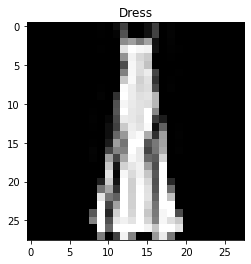

In [11]:
import matplotlib.pyplot as plt

image, label = train_data[0]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

Let's plot some more.

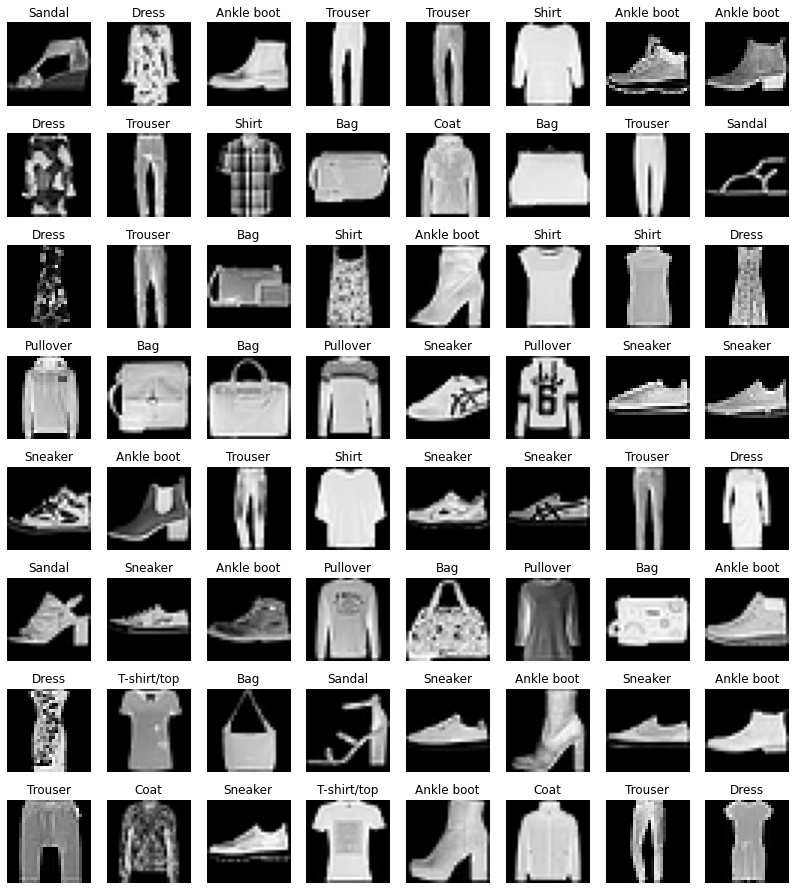

In [12]:
fig = plt.figure(figsize=(14, 16))
rows, cols = 8, 8
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

Up till now we have updated the modelparameters once in each epoch. For large dataset this is highly inefficient. 

It is better to partition the train set into smaller chucks of data, called **batches** (or **minibatches** as this approach works best for very small batch sizes), and update the modelparameters after each batch.  

A minibatch size of [32 data points](https://twitter.com/ylecun/status/989610208497360896?s=20&t=N96J_jotN--PYuJk2WcjMw) is a good place to start for most tasks.

The PyTorch `DataLoader` class makes using minibatches really easy.

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

In [ ]:
from sklearn.model_selection import train_test_split

y = dataset.pop('y')
X = dataset

#create train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#convert to tensors
X_train, X_val, X_test = torch.Tensor(X_train.values),torch.Tensor(X_val.values),torch.Tensor(X_test.values)
y_train, y_val, y_test = torch.Tensor(y_train.values),torch.Tensor(y_val.values),torch.Tensor(y_test.values)

## Building the model

We increase the complexity of our model by adding an additional linear layer to the **model architecture**.   

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        num_neurons_layer_2 = 6

        self.layer_1 = nn.Linear(in_features=input_dim, out_features=num_neurons_layer_2)
        self.layer_2 = nn.Linear(in_features=num_neurons_layer_2, out_features=output_dim)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.layer_2(x)
        return x

### `__init()__`

Our neural network has two linear layers. The first layer `layer_1` has `input_dim` (the number of features in our dataset) input features that form the **input layer**. It has `num_neurons_layer_2` output features that form the **hidden layer** where these features are typically called **hidden neurons**.

The second layer `layer_2` has `num_neurons_layer_2` input features (neurons) and `output_dim` (which equals to 1 for two-class classification) output features, the **output layer**.

An example of this model architecture with `num_neurons_layer_2 = 6` can be seen [here](https://playground.tensorflow.org/#activation=sigmoid&batchSize=30&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=6&seed=0.86658&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

We will use the Rectified Linear Unit (ReLU) activation function in the hidden layer. In the output layer we use the sigmoid function (through `BCEWithLogitsLoss`, so we not to explicitly apply the sigmoid function during inference (see notebook about logistic regression)).

Next, we create an instance of the class `NeuralNetwork`.

In [ ]:
# Two inputs x_1 and x_2
input_dim = 2  
# Single binary output 
output_dim = 1 

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model = NeuralNetwork(input_dim, output_dim)

model.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.2278, -0.6223],
                      [ 0.0246, -0.4814],
                      [ 0.3607,  0.4794],
                      [-0.6118, -0.0522],
                      [-0.4982, -0.1984],
                      [ 0.6120, -0.6830]])),
             ('layer_1.bias',
              tensor([ 0.6697, -0.1261,  0.5120,  0.5373,  0.2219,  0.4458])),
             ('layer_2.weight',
              tensor([[-0.0155,  0.1950, -0.3828,  0.1673,  0.1930, -0.3202]])),
             ('layer_2.bias', tensor([-0.2894]))])

Let's plot the decision boundary of this initial neural network.

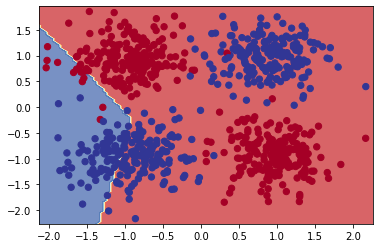

In [ ]:
plot_decision_boundary(model, X_train, y_train)

### `forward()`

The `forward()` method applies the neural network to the provided feature vectors. Here we see that the data is first passed through `layer_1`, then through the ReLU activations that then pass through `layer_2`.

In [ ]:
from sklearn.metrics import accuracy_score

with torch.inference_mode(): 
    predictions = model(X_test)

predictions = torch.squeeze(torch.round(torch.sigmoid(predictions)))
predictions = predictions.detach().numpy()

print("test set accuracy: {}".format(accuracy_score(y_test,predictions)))

test set accuracy: 0.52


## Training the model

We use `BCEWithLogitsLoss` as the loss function and SGD, `torch.optim.SGD(params, lr)` as the optimizer.

In [ ]:
learning_rate = 0.005

#the loss function
loss_func = torch.nn.BCEWithLogitsLoss()

#the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now we can create and run our training and validation loop.



training loss: 0.7200626134872437
validation accuracy: 0.6


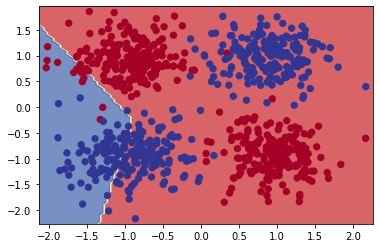

training loss: 0.6523182392120361
validation accuracy: 0.61


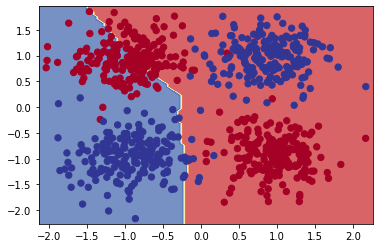

training loss: 0.608246922492981
validation accuracy: 0.6


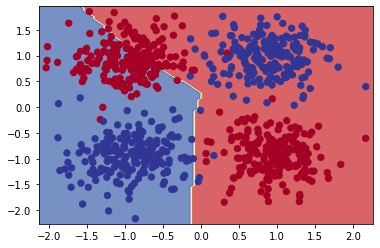

training loss: 0.5621764659881592
validation accuracy: 0.65


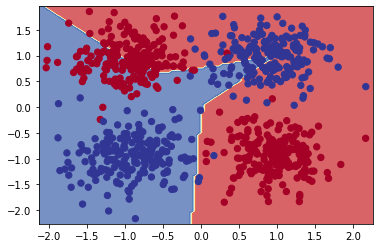

training loss: 0.5165428519248962
validation accuracy: 0.82


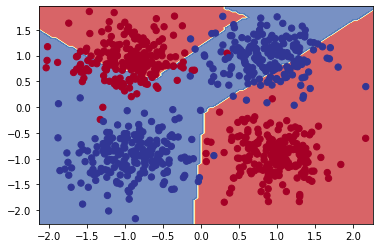

training loss: 0.47056180238723755
validation accuracy: 0.88


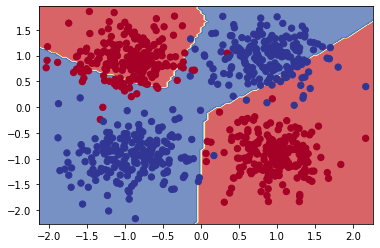

training loss: 0.4203900992870331
validation accuracy: 0.91


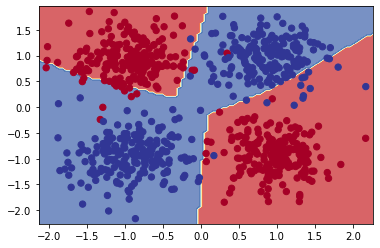

training loss: 0.36573660373687744
validation accuracy: 0.96


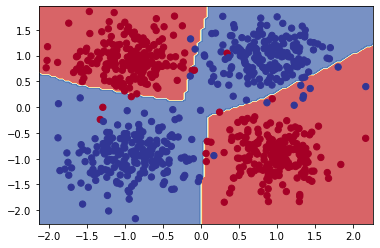

training loss: 0.3104765713214874
validation accuracy: 0.96


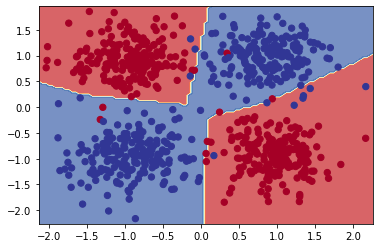

training loss: 0.26015859842300415
validation accuracy: 0.97


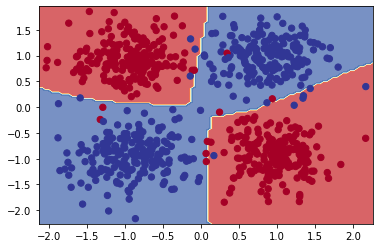

training loss: 0.21756507456302643
validation accuracy: 0.97


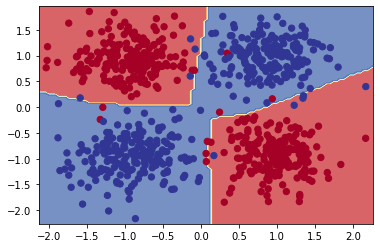

training loss: 0.1841445118188858
validation accuracy: 0.97


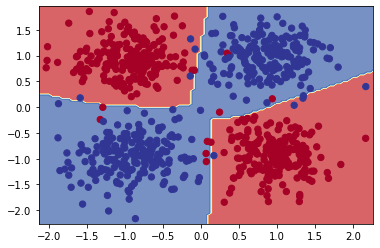

training loss: 0.1584366410970688
validation accuracy: 0.98


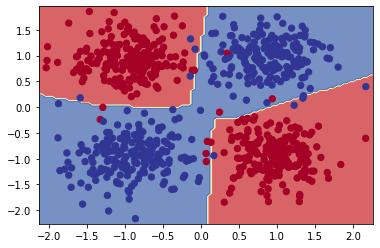

training loss: 0.1389921009540558
validation accuracy: 0.98


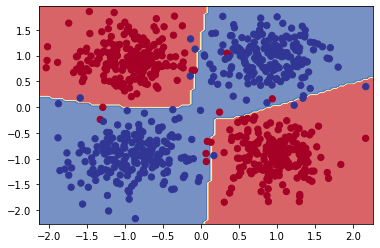

training loss: 0.1238783746957779
validation accuracy: 0.98


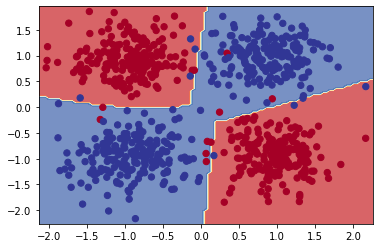

training loss: 0.11188086867332458
validation accuracy: 0.98


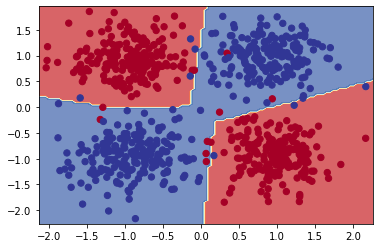

In [ ]:
#number of times we iterate trough the train set
num_epochs = 8000

for epoch in range(num_epochs):

    #step 1
    predictions_train = torch.squeeze(model(X_train)) 

    #step 2
    loss = loss_func(predictions_train, y_train) 

    #step 3
    optimizer.zero_grad() 

    #step 4
    loss.backward() 

    #step 5
    optimizer.step() 
        
    if epoch % 500 == 0:    
      print("training loss: {}".format(loss))    
      model.eval()
      with torch.inference_mode(): 
        predictions_val = torch.squeeze(torch.round(torch.sigmoid(model(X_val)))).detach().numpy()
        print("validation accuracy: {}".format(accuracy_score(y_val,predictions_val)))
      model.train()
      plot_decision_boundary(model, X_train, y_train)
      plt.show()


## Computing predictions and evaluating the model


In [ ]:
model.eval()

with torch.inference_mode(): 
    predictions_test = model(X_test)

predictions_test = torch.round(torch.sigmoid(torch.squeeze(predictions_test))).detach().numpy()

print("test set accuracy: {}".format(accuracy_score(y_test,predictions_test)))

test set accuracy: 0.97


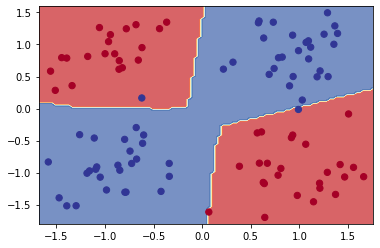

In [ ]:
plot_decision_boundary(model, X_test, y_test)